# **Entrenamiento y predicción del modelo - Monografia**
## Mateo Usme - 1017264083
## Jorge Rojas - 71690015
## Universidad de Antioquia

## Instalar librerias

Ocurre un error al instalar completa la librería [Darts](https://unit8co.github.io/darts/#:~:text=darts%20is%20a%20Python%20library,%2C%20similar%20to%20scikit%2Dlearn.), se instala lo necesario.

PyYAML se instala de nuevo con una version compatible pues genera error con Darts en su version mas reciente.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install u8darts
!pip install 'u8darts[pmdarima]'
!pip install 'u8darts[torch]'
!pip install 'u8darts[prophet]'
!pip install pyyaml==5.4.1
!pip install matplotlib==3.1.3

In [3]:
## Librerías base

import pandas as pd
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import datetime as dt


## Importaciones de Darts 

from darts import TimeSeries
from darts.metrics import mape, rmsle
from darts.utils.statistics import check_seasonality, plot_residuals_analysis
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    Theta,
    RandomForest
)
import pmdarima as pmd

## Pre-procesamiento de datos

Importamos los datos con una configuración inicial para la fecha, observamos su distribución y filtramos los necesarios para procesar con *Darts*.

In [4]:
data = pd.read_csv(r"https://github.com/MateoUsme/Esp_Analitica/raw/main/dato_producto.csv")
data

,FechaFactura,Week,Year,NumSemana,Codigo,Kilos
0,2010-03-04,2010-09,2010,9,688706,633.60
1,2010-03-05,2010-09,2010,9,688706,201.60
2,2010-03-05,2010-09,2010,9,688706,216.00
3,2010-03-05,2010-09,2010,9,688706,381.60
4,2010-03-05,2010-09,2010,9,688706,856.80
...,...,...,...,...,...,...
3891,2022-01-17,2022-03,2022,3,688706,1041.98
3892,2022-01-18,2022-03,2022,3,688706,2993.76
3893,2022-01-21,2022-03,2022,3,688706,6197.47
3894,2022-01-25,2022-04,2022,4,688706,5116.61


In [5]:
data.FechaFactura = pd.to_datetime(data.FechaFactura, format="%Y-%m-%d")
data.set_index("FechaFactura", drop=True, inplace=True)
data = data.filter(["Kilos"])[2600:]

In [6]:
data = data.resample("M").sum()+1

In [7]:
data.head()

,Kilos
FechaFactura,
2018-11-30,922.6
2018-12-31,110247.4
2019-01-31,36202.6
2019-02-28,35353.0
2019-03-31,76954.6


## Procesamiento con Darts

Se convierte al tipo de dato que ofrece *Darts* para poder procesar la serie de tiempo y se empiezan a realizar test y predicciones sobre temporalidad sobre varios modelos ya importados.

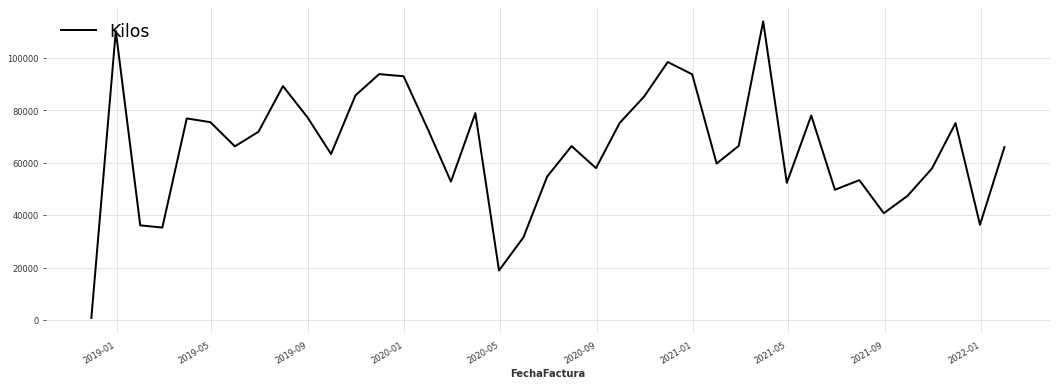

In [8]:
series = TimeSeries.from_dataframe(data)

plt.figure(figsize=(18,6))
series.plot()
plt.legend(loc="upper left", fontsize="xx-large")

In [9]:
ALPHA = 0.05

for m in range(2, 25):
    is_seasonal, mseas = check_seasonality(series, m=m, alpha=ALPHA)
    if is_seasonal:
        break

print("Tiene estacionalidad? " + str(is_seasonal))
if is_seasonal:
    print('Hay estacionalidad de orden {}.'.format(mseas))

Tiene estacionalidad? True
Hay estacionalidad de orden 3.


Se observa con la función **check_seasonality** de *Darts* que emplea la función de autocorrelación (ACFF) si existe estacionalidad en la serie de tiempo.

Dividimos nuestra serie de tiempo en conjuntos de entrenamiento 70% y 30% validación.

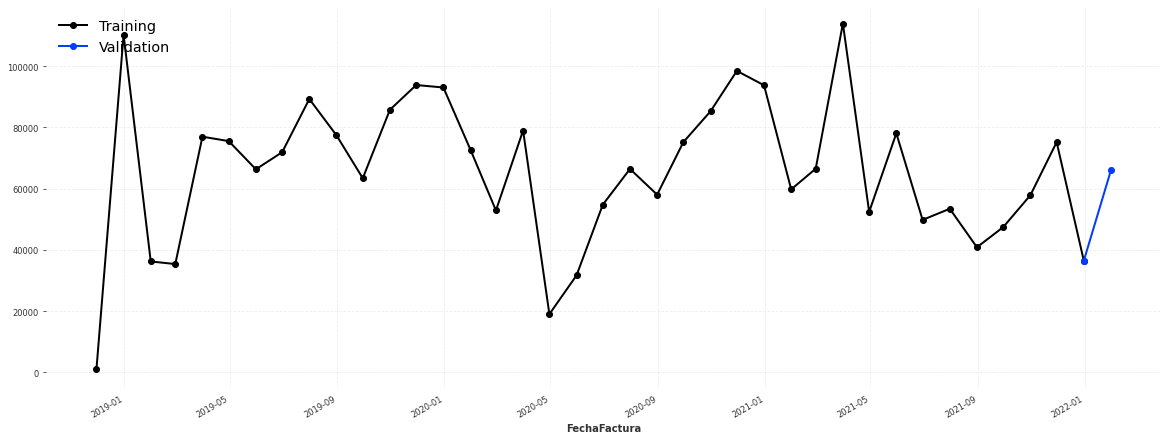

In [10]:
train, val = series[:-2], series[-2:]
plt.figure(figsize=(20,7))
series[:-1].plot(label="Training", marker='o')
val.plot(label="Validation", marker='o')
plt.grid(linestyle='--',alpha=0.5)
plt.legend(loc="upper left", fontsize="x-large")

Instanciamos los modelos que hemos importado de *Darts* para compararlos más adelante:

In [11]:
def eval_model(model):
    t_start =  time.perf_counter()
    print("beginning: " + str(model))


    # Realizamos fit y obtenemos
    res = model.fit(train)
    forecast = model.predict(len(val))

    # for naive forecast, concatenate seasonal fc with drift fc
    if model == m_naive:
        if is_seasonal:
            fc_drift = forecast
            modelS = NaiveSeasonal(K=mseas)
            modelS.fit(train)
            fc_seas = modelS.predict(len(val))
            forecast = fc_drift + fc_seas - train.last_value()


    # Calcular métricas y tiempo de ejecución del modelo
    
    res_mape = mape(val, forecast)
    res_rmsle = rmsle(val, forecast)
    res_time = time.perf_counter() - t_start
    res_accuracy = {"MAPE":res_mape, "RMSLE":res_rmsle, "tiempo":res_time}

    results = [forecast, res_accuracy]
    print("completed: " + str(model) + ":" + str(res_time) + "sec")
    return results

In [ ]:
m_naive = NaiveDrift();

#-----

if is_seasonal:
    m_expon = ExponentialSmoothing(seasonal_periods=mseas);
else:
    m_expon = ExponentialSmoothing();

#-----

y = np.asarray(series.pd_series())
n_kpss = pmd.arima.ndiffs(y, alpha=ALPHA, test='kpss', max_d=2);
n_adf = pmd.arima.ndiffs(y, alpha=ALPHA, test='adf', max_d=2);
n_diff = max(n_adf, n_kpss)

n_ocsb = pmd.arima.OCSBTest(m=max(4,mseas)).estimate_seasonal_differencing_term(y);
n_ch = pmd.arima.CHTest(m=max(4,mseas)).estimate_seasonal_differencing_term(y);
ns_diff = max(n_ocsb, n_ch, is_seasonal * 1)

#-----

m_arima = AutoARIMA(
    start_p=1, d=n_diff, start_q=1,
    max_p=4, max_d=n_diff, max_q=4,
    start_P=0, D=ns_diff, start_Q=0, m=max(4,mseas), seasonal=is_seasonal,
    max_P=3, max_D=1, max_Q=3,
    max_order=5,                       
    stationary=False, 
    information_criterion="bic", alpha=ALPHA, 
    test="kpss", seasonal_test="ocsb",
    stepwise=True, 
    suppress_warnings=True, error_action="trace", trace=True, with_intercept="auto");

#-----

thetas = 2 - np.linspace(-10, 10, 100)
best_mape = float('inf')
best_theta = 0

for theta in thetas:
    model = Theta(theta);
    res = model.fit(train);
    pred_theta = model.predict(len(val));
    res_mape = mape(val, pred_theta);

    if res_mape < best_mape:
        best_mape = res_mape
        best_theta = theta

m_theta = Theta(best_theta) ;

#-----

m_randomforest = RandomForest(lags=20, n_estimators = 10, max_depth = 5);


#------
#------

models = [ 
    m_expon, 
    m_theta, 
    m_arima,
    m_naive, 
    m_randomforest]

## Evaluación de modelos

Se agrupan los modelos que van a ser evaluados de acuerdo a las características definidas en el anterior paso para cada uno

In [13]:
# call the forecasters one after the other
model_titles = ['Exponential Smoothing','Theta','ARIMA','NAIVE','Random Forest']
model_predictions = [eval_model(model) for model in models];

beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.2767031950000103sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.09587238500000694sec
beginning: Auto-ARIMA
Performing stepwise search to minimize bic
 ARIMA(1,2,1)(0,1,0)[4]             : BIC=741.774, Time=0.13 sec
 ARIMA(0,2,0)(0,1,0)[4]             : BIC=776.806, Time=0.04 sec
 ARIMA(1,2,0)(1,1,0)[4]             : BIC=751.472, Time=0.13 sec
 ARIMA(0,2,1)(0,1,1)[4]             : BIC=743.562, Time=0.19 sec
 ARIMA(1,2,1)(1,1,0)[4]             : BIC=741.442, Time=0.14 sec
 ARIMA(1,2,1)(2,1,0)[4]             : BIC=741.500, Time=0.25 sec
 ARIMA(1,2,1)(1,1,1)[4]             : BIC=743.004, Time=0.26 sec
 ARIMA(1,2,1)(0,1,1)[4]             : BIC=739.597, Time=0.36 sec
 ARIMA(1,2,1)(0,1,2)[4]             : BIC=742.957, Time=0.19 sec
 ARIMA(1,2,1)(1,1,2)[4]             : BIC=746.085, Time=0.53 sec
 ARIMA(1,2,0)(0,1,1)[4]             : 

Se buscan los mejores resultados de diferentes métricas para cada modelo

In [14]:
df_acc = pd.DataFrame.from_dict(model_predictions[0][1], orient="index")
df_acc.columns = ['Exponential Smoothing']

for i, m in enumerate(models):
    if i > 0: 
        df = pd.DataFrame.from_dict(model_predictions[i][1], orient="index")
        df.columns = [model_titles[i]]
        df_acc = pd.concat([df_acc, df], axis=1)
    i +=1

pd.set_option("display.precision",3)
df_acc.style.highlight_min(color="green", axis=1).highlight_max(color="darkorange", axis=1)

,Exponential Smoothing,Theta,ARIMA,NAIVE,Random Forest
MAPE,57.599,64.464,25.182,20.953,60.770
RMSLE,0.522,0.557,0.247,0.221,0.525
tiempo,0.277,0.096,9.236,0.046,0.084


2022-06-03 04:17:40 matplotlib.legend WARNING: No handles with labels found to put in legend.
2022-06-03 04:17:40 matplotlib.legend WARNING: No handles with labels found to put in legend.
2022-06-03 04:17:40 matplotlib.legend WARNING: No handles with labels found to put in legend.
2022-06-03 04:17:40 matplotlib.legend WARNING: No handles with labels found to put in legend.
2022-06-03 04:17:40 matplotlib.legend WARNING: No handles with labels found to put in legend.
2022-06-03 04:17:40 matplotlib.legend WARNING: No handles with labels found to put in legend.
2022-06-03 04:17:40 matplotlib.legend WARNING: No handles with labels found to put in legend.
2022-06-03 04:17:40 matplotlib.legend WARNING: No handles with labels found to put in legend.
2022-06-03 04:17:40 matplotlib.legend WARNING: No handles with labels found to put in legend.
2022-06-03 04:17:40 matplotlib.legend WARNING: No handles with labels found to put in legend.


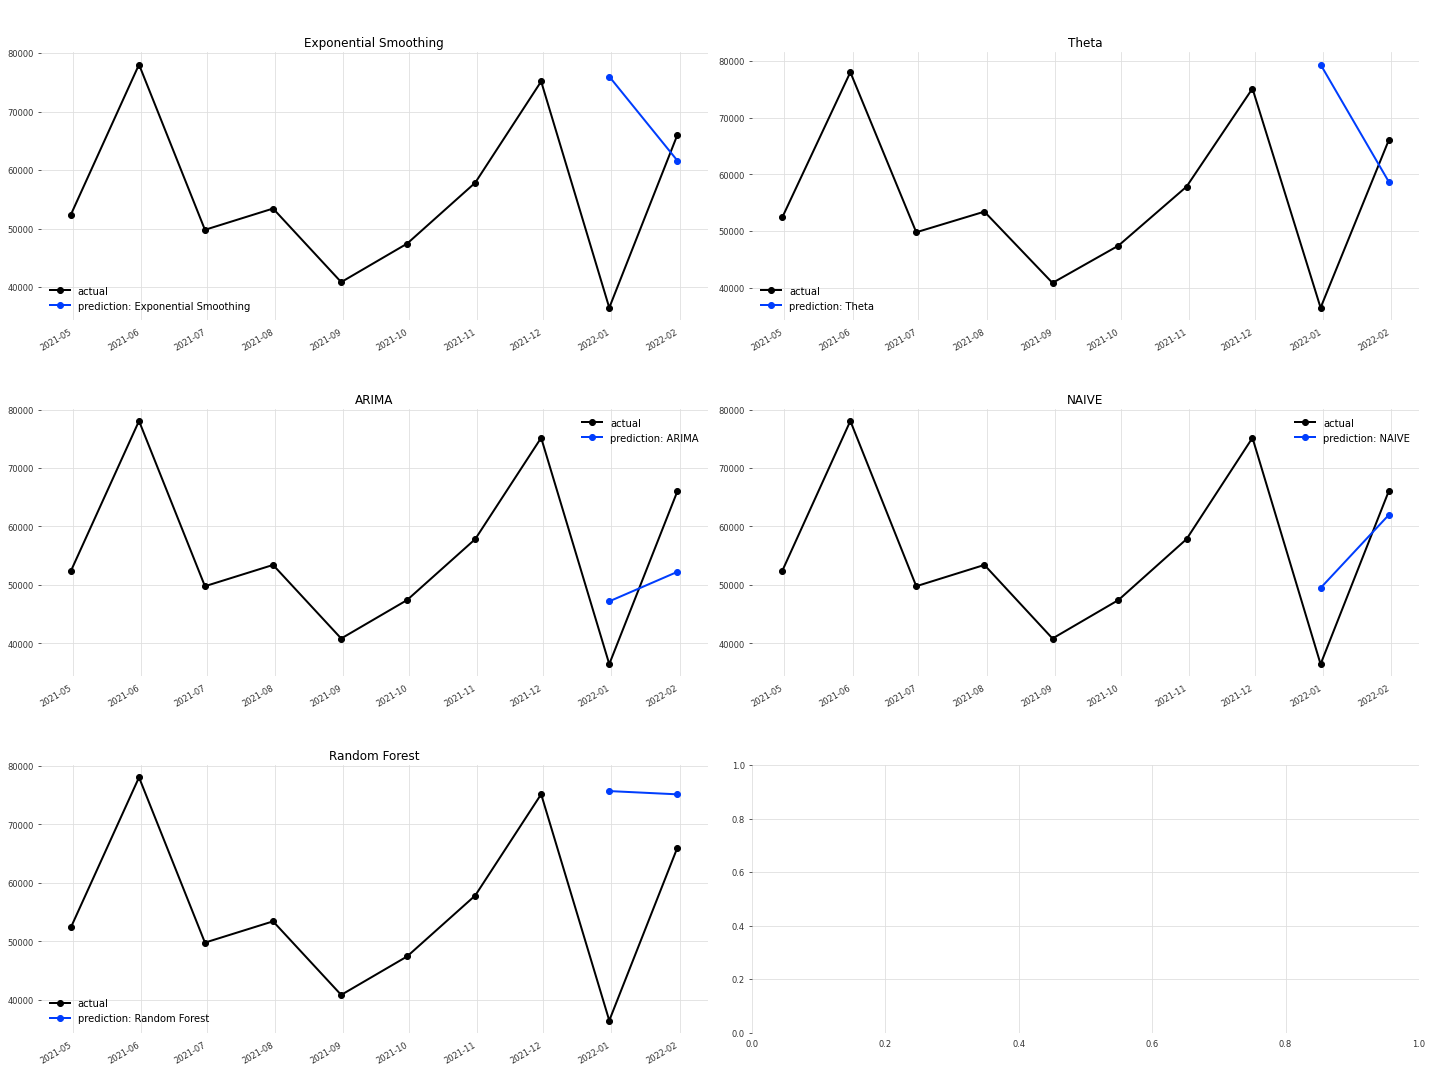

In [15]:
# plot the forecasts

pairs = math.ceil(len(models)/2)                    # how many rows of charts
fig, ax = plt.subplots(pairs, 2, figsize=(20, 5 * pairs))
ax = ax.ravel()

model_titles = ['Exponential Smoothing','Theta','ARIMA','NAIVE','Random Forest']

for i,m in enumerate(models):
        series[-10:].plot(label="actual", ax=ax[i], marker='o')
        model_predictions[i][0].plot(label="prediction: "+model_titles[i], ax=ax[i], marker='o')
        
        mape_model =  model_predictions[i][1]["MAPE"]
        time_model =  model_predictions[i][1]["tiempo"]
        ax[i].set_title("\n\n" + model_titles[i])

        ax[i].set_xlabel("")
        ax[i].legend()

plt.tight_layout()